# _Stjórn_ Stylometry

| Work         | Date             | Material      | Incipit                                                                         |
| ------------ | ---------------- | ------------- | ------------------------------------------------------------------------------- |
| _Stjórn I_   | s. xiv in.       | Gn--Ex 18.27  | i upphafi skapadi gud himin þat er sealft himinriki                             |
| _Stjórn II_  | s. xiii in.      | Ex 19--Dt     | a þridia manadi eptir brottfaur gydinga af egiptalandi komu þeir i audn synay   |
| _Stjórn III_ | s. xiii med.     | Ios           | moyses agietr guds uin aðr hann andadizt hafðe at guds raaðe                    |
| _Stjórn IV_  | ?                | Ios           | eptir andlat moyses ok harmsong þann er gydingar sungu eptir hann               |
| _Stjórn III_ | as above         | Idc--Rg       | efter andlat iosue læitaði israels lyðr raðs uið guð sua segiandi               |

Unger's edition follows AM 226 (written 1360x1370); Astås primarily follows AM 227 (written ca. 1350). _Stjórn IV_ refers to a shorter redaction of the material from the Book of Joshua, drawn from Peter Comestor's _Historica Scholastica_ and contained in AM 226 (and copied thence into AM 225). Unger prints both III and IV.

In [1]:
import os,glob,json,copy,statistics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import numpy as np
import pandas as pd
from bisect import bisect_left
from lexicalrichness import LexicalRichness
%matplotlib inline

def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


In [2]:
chunk_size = 2000

In [3]:
with open('token_indices.json') as index_file:
    token_indices = json.load(index_file)

titles = ['prologue', 'introduction', 'gn', 'ex', 'lv', 'nm', 'dt', 'ios', 'idc', 'rt', '1sm', '2sm', '3rg', '4rg']
work_indices = {
    'stjorn1': 650,
    'stjorn2': 124417,
    'stjorn3a': 147678,
    'stjorn4': 156943,
    'stjorn3b': 160719
}

tokens = []
for title in titles:
    with open(f"nlp/{title}.txt") as raw:
        document = raw.read().replace('\n', ' ')
        tokens.extend(document.split())

In [4]:
text = dict()
section_list = list(token_indices.keys())
for index,section in enumerate(section_list):
    if section == section_list[-1]:
            continue
            # NB this means the last entry is not counted. Change this to measure from len(tokens) once the incipits are complete.
    else:
        next = section_list[index+1]
        text[section] = tokens[token_indices[section]:token_indices[next]]


In [5]:
reverse_index = {v: k for k, v in token_indices.items()}
def index_to_identifiers(needle, haystack=list(token_indices.values())):
    pos_start = bisect_left(haystack, needle)
    pos_end = bisect_left(haystack, needle+chunk_size)
    if pos_start == 0:
        start = reverse_index[haystack[0]]
        end = reverse_index[haystack[pos_end - 1]]
    else:
        start = reverse_index[haystack[pos_start - 1]]
        end = reverse_index[haystack[pos_end - 1]]
    # if BOTH are in the Prologue range (only happens with chunk sizes below 650 tokens):
    if needle+chunk_size < work_indices['stjorn1']:
        color = ('#C7472E', '#C7472E')
    # if BOTH are in the Stjórn I range:
    elif work_indices['stjorn1'] <= needle < work_indices['stjorn2'] and work_indices['stjorn1'] <= needle+chunk_size < work_indices['stjorn2']:
        color = ('#264FA6', '#264FA6')
    # if BOTH are in the Stjórn II range:
    elif work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn2'] <= needle+chunk_size < work_indices['stjorn3a']:
        color = ('#C27A13', '#C27A13')#orange
    # if BOTH are in the Stjórn III range:
    elif needle >= work_indices['stjorn3b'] or (work_indices['stjorn3a'] <= needle < work_indices['stjorn4'] and work_indices['stjorn3a'] <= needle+chunk_size < work_indices['stjorn4']):
        color = ('#355E26', '#355E26')#green
    # if BOTH are in the Stjórn IV range:
    elif work_indices['stjorn4'] <= needle < work_indices['stjorn3b'] and work_indices['stjorn4'] <= needle+chunk_size < work_indices['stjorn3b']:
        color = ('#ABA75B', '#ABA75B')#cameo
    # if START is in the Prologue but END is in Stjórn I:
    elif needle <= work_indices['stjorn1'] and work_indices['stjorn1'] <= needle+chunk_size < work_indices['stjorn2']:
        color = ('#C7472E', '#264FA6')
     # if START is in Stjórn I but END is in Stjórn II:
    elif work_indices['stjorn1'] <= needle < work_indices['stjorn2'] and work_indices['stjorn2'] <= needle+chunk_size < work_indices['stjorn3a']:
        color = ('#264FA6', '#C27A13')
    # if START is in Stjórn II but END is in Stjórn III:
    elif work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn3a'] <= needle+chunk_size < work_indices['stjorn4']:
        color = ('#C27A13', '#355E26')
    # if START is in Stjórn III but END is in Stjórn IV:
    elif work_indices['stjorn3a'] <= needle and work_indices['stjorn4'] <= needle+chunk_size < work_indices['stjorn3b']:
        color = ('#355E26', '#ABA75B')
    # if START is in Stjórn IV but END is in Stjórn III:
    elif work_indices['stjorn4'] <= needle and work_indices['stjorn3b'] <= needle+chunk_size:
        color = ('#ABA75B', '#355E26')

    if start == end:
        return (start, color)
    else:
        return (start + '–' + end, color)

In [6]:
test = index_to_identifiers(160000)
print(test)

('ios15-18(stj4)–idc2', ('#ABA75B', '#355E26'))


In [7]:
chunks = dict()
index_counter = 0
while index_counter < len(tokens):
    current_index = copy.copy(index_counter)
    if len(tokens)-current_index < chunk_size:
        chunk = tokens[current_index:]
    else:
        chunk = tokens[current_index:current_index+chunk_size]
        chunks[current_index] = (index_to_identifiers(current_index)[0], index_to_identifiers(current_index)[1], chunk)
    index_counter = current_index + chunk_size
current_index = len(tokens) - (len(tokens) % chunk_size) -1
remnant = tokens[current_index:]
chunks[current_index] = (index_to_identifiers(current_index)[0], index_to_identifiers(current_index)[1], remnant)

In [8]:
ld = list()

for chunk in chunks.values():
    lex = LexicalRichness(chunk[2], preprocessor=None, tokenizer=None)
    ld.append((chunk[0], chunk[1], lex.ttr))

In [9]:
print(ld)

[('prologue–introduction', ('#C7472E', '#264FA6'), 0.4185), ('introduction–gn1', ('#264FA6', '#264FA6'), 0.4205), ('gn1', ('#264FA6', '#264FA6'), 0.3905), ('gn1', ('#264FA6', '#264FA6'), 0.4075), ('gn1–gn2', ('#264FA6', '#264FA6'), 0.398), ('gn2', ('#264FA6', '#264FA6'), 0.424), ('gn2–gn3', ('#264FA6', '#264FA6'), 0.382), ('gn3', ('#264FA6', '#264FA6'), 0.3865), ('gn3–gn4', ('#264FA6', '#264FA6'), 0.419), ('gn4', ('#264FA6', '#264FA6'), 0.409), ('gn4–gn6', ('#264FA6', '#264FA6'), 0.4415), ('gn6–gn7', ('#264FA6', '#264FA6'), 0.398), ('gn7–gn9', ('#264FA6', '#264FA6'), 0.3945), ('gn9–af skipan heimsins', ('#264FA6', '#264FA6'), 0.4345), ('af skipan heimsins', ('#264FA6', '#264FA6'), 0.4395), ('af skipan heimsins–af egipta landi', ('#264FA6', '#264FA6'), 0.421), ('af egipta landi–af europa', ('#264FA6', '#264FA6'), 0.461), ('af europa–flod', ('#264FA6', '#264FA6'), 0.393), ('flod', ('#264FA6', '#264FA6'), 0.445), ('flod–af affrica', ('#264FA6', '#264FA6'), 0.4165), ('af affrica–belo', ('#

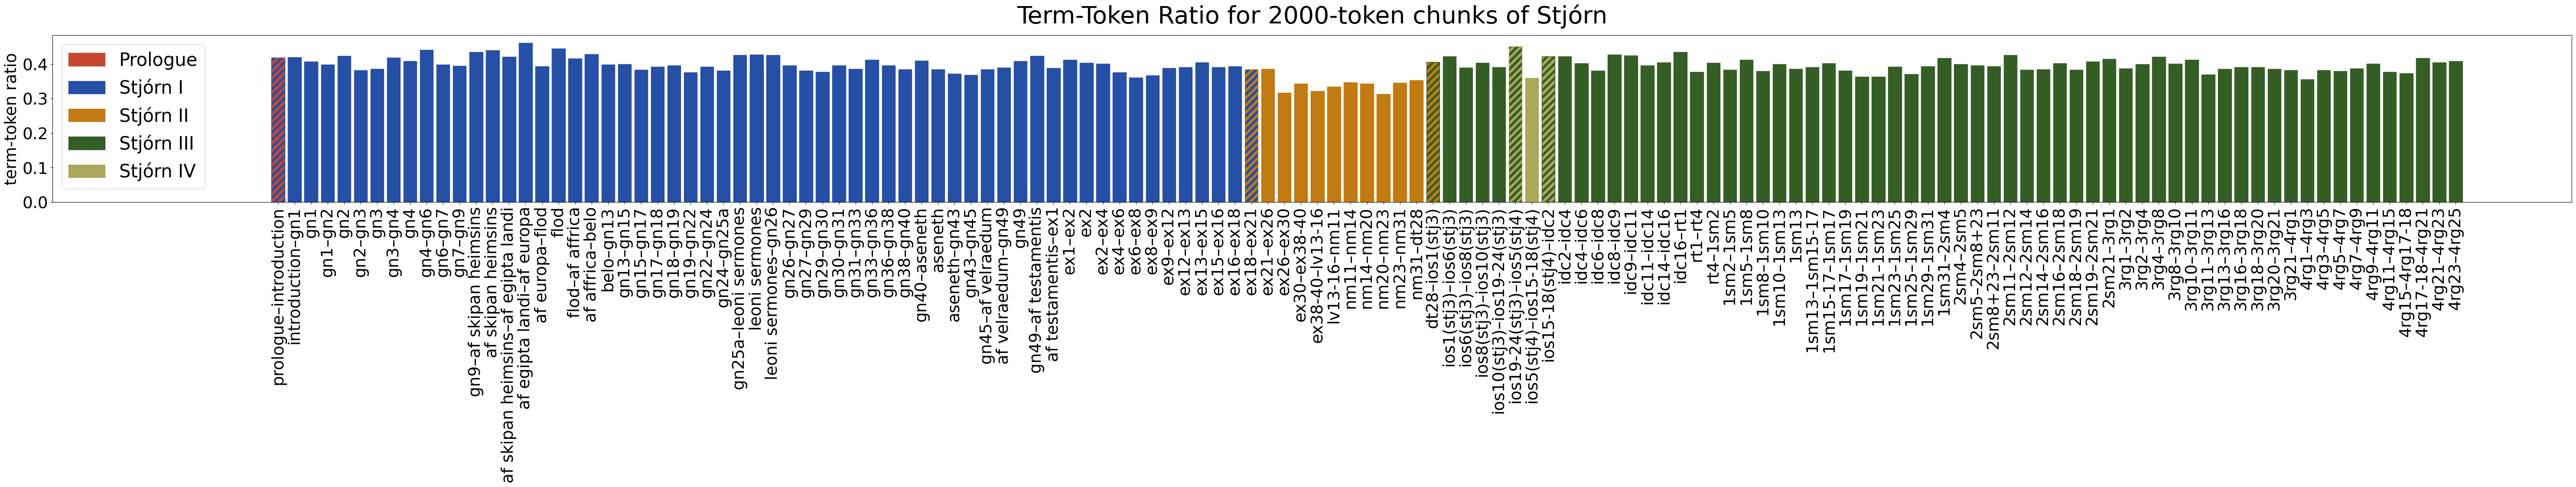

In [10]:
fig, ax = plt.subplots(figsize=(75,5))
x = [p[0] for p in ld]
y = [p[2] for p in ld]
color = [p[1][0] for p in ld]
hatch_color =[p[1][1] for p in ld]
ax.bar(x,y, color=color, edgecolor=hatch_color, hatch="//", lw=1., zorder = 0)
ax.set_ylabel('term-token ratio', fontsize='27')
ax.set_title('Term-Token Ratio for ' + str(chunk_size) + '-token chunks of Stjórn', fontsize='40', pad='20')
plt.xticks(rotation='vertical')
rcParams['hatch.linewidth'] = 4
legend_data = [
    mpatches.Patch(color='#C7472E', label='Prologue'), 
    mpatches.Patch(color='#264FA6', label='Stjórn I'), 
    mpatches.Patch(color='#C27A13', label='Stjórn II'), 
    mpatches.Patch(color='#355E26', label='Stjórn III'), 
    mpatches.Patch(color='#ABA75B', label='Stjórn IV')
    ]
plt.legend(handles=legend_data, loc='upper left', prop={'size': 30})
ax.tick_params(axis='both', which='major', labelsize=27)
#plt.subplots_adjust(wspace=0.8)
set_xmargin(ax, left=0.1, right=0.05)
plt.savefig(fname='ttf.svg', format='svg', bbox_inches='tight')
plt.show()


TODO: print average 1250-word TTR for the four main works

In [11]:
def ttravg(start, stop, chunksize=1000):
    data = []
    while (stop - start) >= chunksize:
        chunk = tokens[start:start+chunksize]
        lex = LexicalRichness(chunk, preprocessor=None, tokenizer=None)
        data.append(lex.ttr)
        start += chunksize
    return round(statistics.fmean(data), 2)

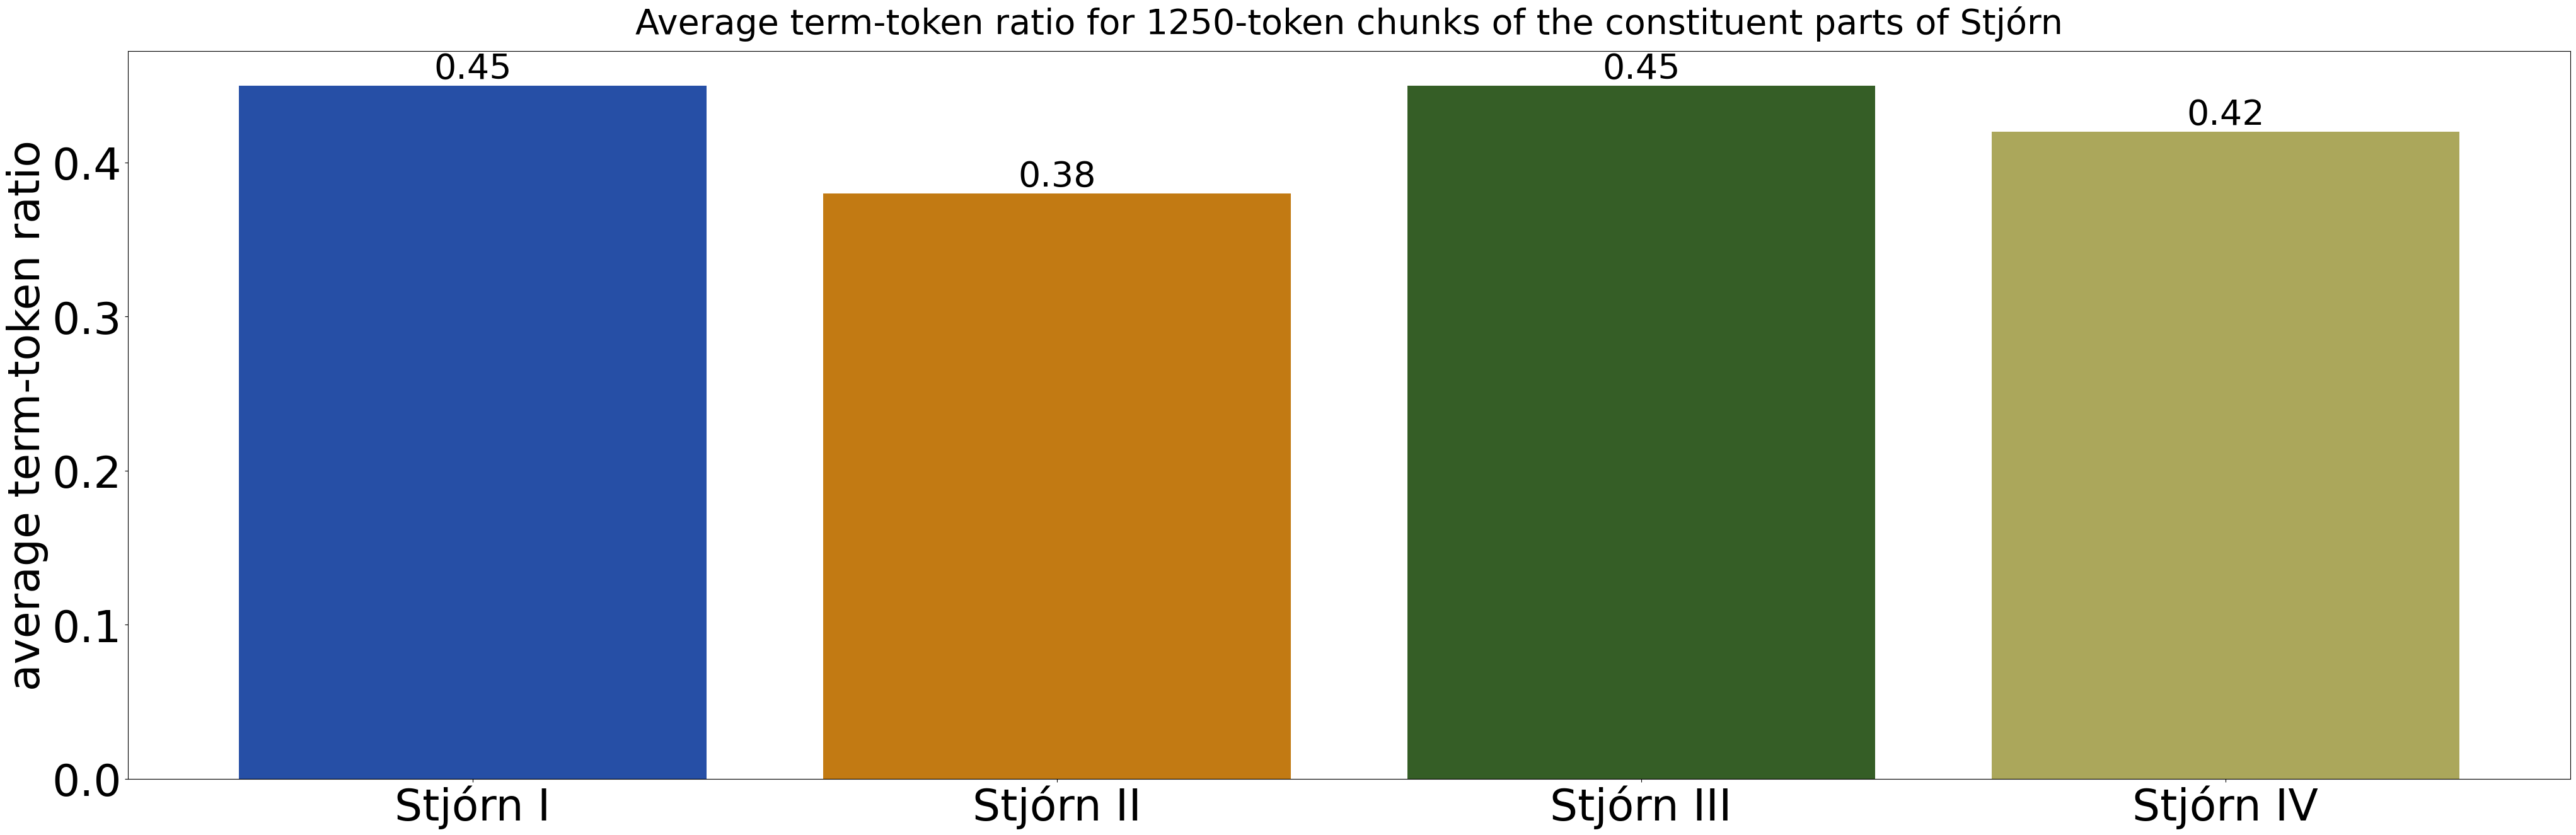

In [12]:
stj1_ttr = ttravg(work_indices['stjorn1'], work_indices['stjorn2'], 1250)
stj2_ttr = ttravg(work_indices['stjorn2'], work_indices['stjorn3a'], 1250)
stj3_ttr = round(statistics.fmean([ttravg(work_indices['stjorn3a'], work_indices['stjorn4'], 1250), ttravg(work_indices['stjorn3b'], len(tokens)-1, 1250)]), 2)
stj4_ttr = ttravg(work_indices['stjorn4'], work_indices['stjorn3b'], 1250)

fig, ax = plt.subplots(figsize=(50,15))
x = ['Stjórn I', 'Stjórn II', 'Stjórn III', 'Stjórn IV']
y = [stj1_ttr, stj2_ttr, stj3_ttr, stj4_ttr]
color = ['#264FA6', '#C27A13', '#355E26', '#ABA75B']
ax.bar(x,y, color=color)
ax.set_ylabel('average term-token ratio', fontsize='50')
ax.set_title('Average term-token ratio for 1250-token chunks of the constituent parts of Stjórn', fontsize='40', pad='20')
plt.xticks()
ax.tick_params(axis='both', which='major', labelsize=50)
ax.bar_label(ax.containers[0], label_type='edge', fontsize='40')
plt.savefig(fname='avg_ttf.svg', format='svg')
plt.show()


## Intersection and Difference

For our next exercise, we'll measure the number of terms _Stjórn_ has in common with other Old Norse works. Let's start with absolute intersection and difference. Note that it is important that the level of normalization between all these works be similar, so in the Menota routine elsewhere in this repository I have attempted to mimic Unger's standard.

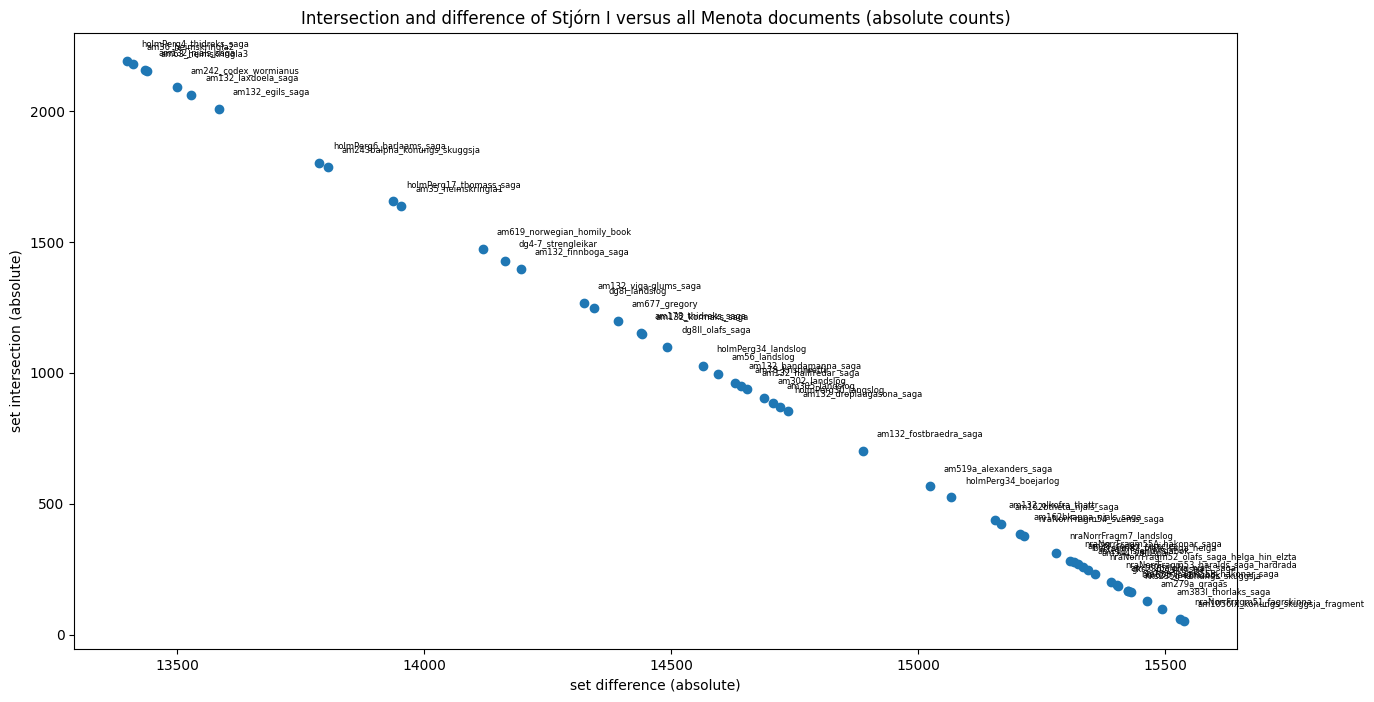

In [29]:
stj1_lexicon = set(tokens[work_indices['stjorn1']:work_indices['stjorn2']])
stj2_lexicon = set(tokens[work_indices['stjorn2']:work_indices['stjorn3a']])
stj3_lexicon = set(tokens[work_indices['stjorn3a']:work_indices['stjorn4']]).union(tokens[work_indices['stjorn3b']:])
stj4_lexicon = set(tokens[work_indices['stjorn4']:work_indices['stjorn3b']])

control = dict()
for text in glob.glob('../menota/dipl/*txt'):
    ref = os.path.basename(text).replace('.txt', '')
    with open(text) as doc:
        _tokens = doc.read().replace('\n', '').split()
        _lexicon = set(_tokens)
        control[ref] = _lexicon

fig, ax = plt.subplots(figsize=(15,8))
x = [len(stj1_lexicon.difference(v)) for k,v in control.items()]
y = [len(stj1_lexicon.intersection(v)) for k,v in control.items()]
types = control.keys()
ax.set_title('Intersection and difference of Stjórn I versus all Menota documents (absolute counts)')
ax.set_xlabel('set difference (absolute)')
ax.set_ylabel('set intersection (absolute)')
for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points', fontsize=6)
plt.scatter(x,y)

OK that's a little useless: long texts have high intersect values and low difference values. Let's try using the intersection/difference ratio as a measure. We need a tabular format, too:



In [ ]:
intersection_data = dict()
for k,v in control.items():
    intersection_data[k] = round(len(stj1_lexicon.intersection(v))/len(stj1_lexicon.difference(v)), 2)
intersection_data = {k: v for k, v in sorted(intersection_data.items(), key=lambda item: item[1], reverse=True)}
intersection_data
#df = pd.DataFrame.from_dict(intersection_data, orient='index', columns=['works', 'ratio'])
df = pd.DataFrame(intersection_data.items(), columns=['work', 'ratio'])
df

# TODO: add token count

,work,ratio
0,am63_heimskringla3,0.16
1,holmPerg4_thidreks_saga,0.16
2,am132_njals_saga,0.16
3,am36_heimskringla2,0.16
4,am132_egils_saga,0.15
5,am132_laxdoela_saga,0.15
6,am242_codex_wormianus,0.15
7,am243balpha_konungs_skuggsja,0.13
8,holmPerg6_barlaams_saga,0.13
9,holmPerg17_thomass_saga,0.12


Yeah, that's still no good. I'll have to compensate for length more directly.